# Simple tests on (Siamese) GNNs

A GNN $\mathbf{f}(G)$ should have certain properties:

$\bullet$ **Permutation invariance**. </br>
Given a node permutation $p(G)$, the output should be indifferent:
$$\mathbf{f}(p(G)) = \mathbf{f}(G)$$ </br>

$\bullet$ **Batch invariance**. </br>
Given a batch of $B$ graphs $\mathcal{G} = \left( G_1, G_2, \hdots, G_B \right)$, the order of the graphs shouldn't change the output for a given graph (upto the same permutation):
$$p \begin{bmatrix} \mathbf{f}(G_1) & \mathbf{f}(G_2) & \hdots & \mathbf{f}(G_N) \end{bmatrix}  = \begin{bmatrix} \mathbf{f}(G_{p(1)}) & \mathbf{f}(G_{p(2)}) & \hdots & \mathbf{f}(G_{p(N)}) \end{bmatrix}$$. </br>

A graph Siamese network $\mathbf{g}(G_1, G_2)$ should also have certain properties:

$\bullet$ **Symmetry.** </br>
The Siamese network should be a symmetric function:
$$\mathbf{g}(G_1, G_2) = \mathbf{g}(G_2, G_1)$$

We will check these properties in this notebook.

## Load model

In [21]:
from omegaconf import OmegaConf
from model import GraphMatchingNetwork

# Configurations
cfg = OmegaConf.load("config_ged.yaml")
cfg.model.node_has_features = False
cfg.model.edge_has_features = False

# Load and randomly initialize Siamese model
model = GraphMatchingNetwork(cfg)

## Two random graphs

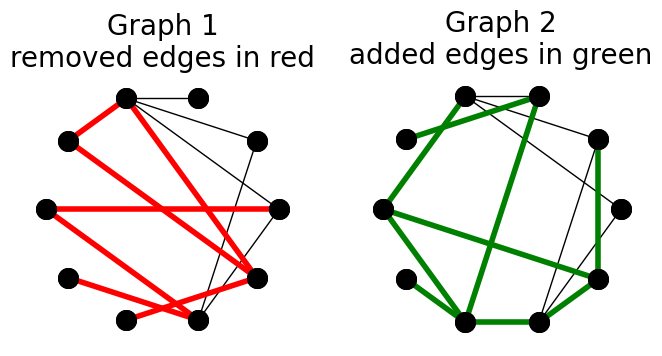

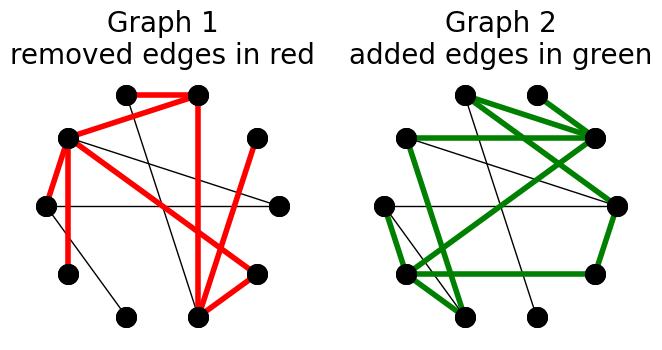

In [22]:
import numpy as np
from utils import generate_binomial_graph, permute_graph_nodes
from plot import plot_difference_graphs

# Sample 2 random binomial graphs
# We set the seed for reproducibility
N, pe = 10, 0.2  # number of nodes; edge probability
G1,_ = generate_binomial_graph(num_nodes=N, pe=pe, seed=1)
G2,_ = generate_binomial_graph(num_nodes=N, pe=pe, seed=1234)

# Plot differences in graphs
plot_difference_graphs(G1, G2)

# Randomly permute graphs
# We set the seed for reproducibility
np.random.seed(1)
pG1 = permute_graph_nodes(G1)
pG2 = permute_graph_nodes(G2)

# Plot differences in permuted graphs
plot_difference_graphs(pG1, pG2)

## Graph- and node-level representations

In [23]:
import networkx as nx
import torch
from torch_geometric.utils import from_networkx
from metrics import euclidean_distance

def graph_inference(graphs, model, s=0.1):
    """Computes node- and graph-level embeddings (ultimate features)
    given a set of graphs and some graph Siamese network model.
    In the case of *graph matching networks*, the number of graphs should be
    multiples of 2, because the batch is treated pair-wise."""

    # Combine the graphs into one
    G = nx.disjoint_union_all(graphs)
    G = from_networkx(G)

    # Prepare the data
    edge_index = G['edge_index']  # edge index
    node_feats = s * torch.ones(G.num_nodes, cfg.model.node_dim)  # node features to all-ones
    edge_feats = s * torch.ones(G.num_edges, cfg.model.edge_dim)  # edge features to all-ones
    batch = torch.cat([i*torch.ones(graphs[i].number_of_nodes(), dtype=torch.int64) for i in range(len(graphs))], dim=0)

    # Feedforward
    model.eval()
    with torch.no_grad():
        _, graph_feats = model(edge_index,
                                        x1=node_feats,
                                        x2=None,
                                        edge_feats=edge_feats,
                                        batch=batch)

        node_feats = model.get_node_features(edge_index,
                                            x1=node_feats,
                                            x2=None,
                                            edge_feats=edge_feats,
                                            batch=batch,
                                            layers=[i+1 for i in range(cfg.model.num_layers)])

        return node_feats, graph_feats

# Graph inference
node_feats, graph_feats = graph_inference([G1, G2], model, s=0.1)
node_feats_K = node_feats[cfg.model.num_layers]

# Print some information
print(f"## Shape node features\n\t{node_feats_K.shape}\n\n"
      f"## Shape graph features\n\t{graph_feats.shape}\n")

# Separate features to G1 and G2
n1, n2 = node_feats_K[:G1.number_of_nodes()], node_feats_K[-G2.number_of_nodes():]
e1, e2 = graph_feats[0], graph_feats[1]

# Check Eucl. distance between embeddings
d = euclidean_distance(e1, e2)
print(f"## Euclidean distance between embeddings\n\t{d}")

## Shape node features
	torch.Size([20, 32])

## Shape graph features
	torch.Size([2, 128])

## Euclidean distance between embeddings
	1.7350830106011017e-08


## Test 1: Symmetry

In [24]:
from plot import plot_graph_features, plot_node_features

def symmetry_check(G1, G2, model):

    # Compute graph-level representation in both orders
    feats_12 = graph_inference([G1, G2], model)[1]
    feats_21 = graph_inference([G2, G1], model)[1]

    # Check similarity
    print(f"Feature similarity Graph 1:\n\t{torch.equal(feats_12[0], feats_21[1])}"
          f"\n\tdE={euclidean_distance(feats_12[0], feats_21[1])}"
          f"\n\tmeanE=(e1_12: {torch.mean(feats_12[0]):.7f}, e1_21: {torch.mean(feats_21[1]):.7f})\n\n"
          f"Features similarity Graph 2:\n\t{torch.equal(feats_12[1], feats_21[0])}"
          f"\n\tdE={euclidean_distance(feats_12[1], feats_21[0])}"
          f"\n\tmeanE=(e2_12: {torch.mean(feats_12[1]):.7f}, e2_21: {torch.mean(feats_21[0]):.7f})")

# Perform symmetry check
symmetry_check(G1, G2, model)

Feature similarity Graph 1:
	False
	dE=2.6020852139652106e-18
	meanE=(e1_12: 0.0099749, e1_21: 0.0099749)

Features similarity Graph 2:
	False
	dE=3.469446951953614e-18
	meanE=(e2_12: 0.0099759, e2_21: 0.0099759)


Surprisingly, the feature vectors are not the same when the order of graphs is switched ...

When we plot feature vectors, one indeed observes that there is a small difference in the representation even when the graphs are the same:

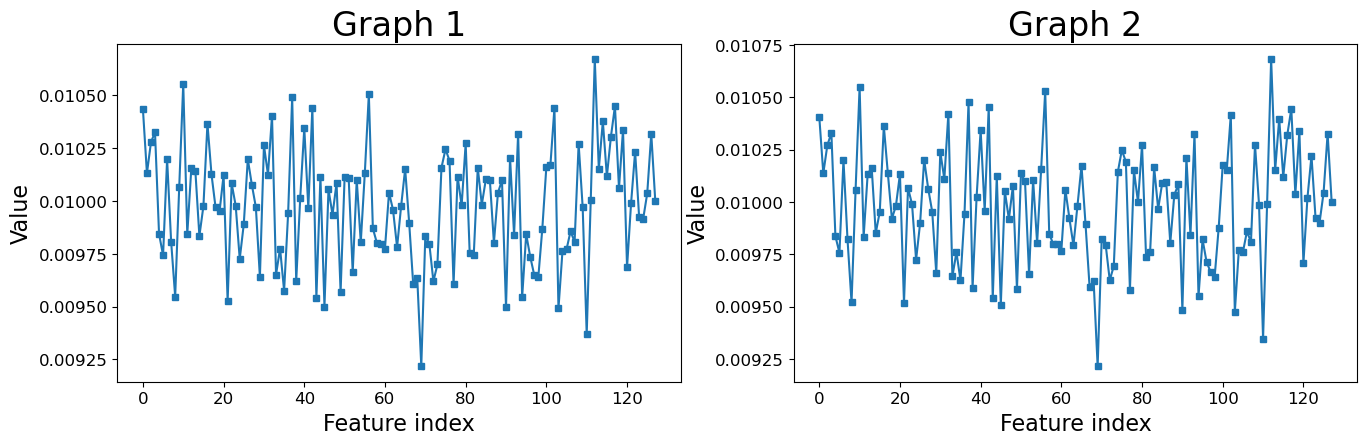

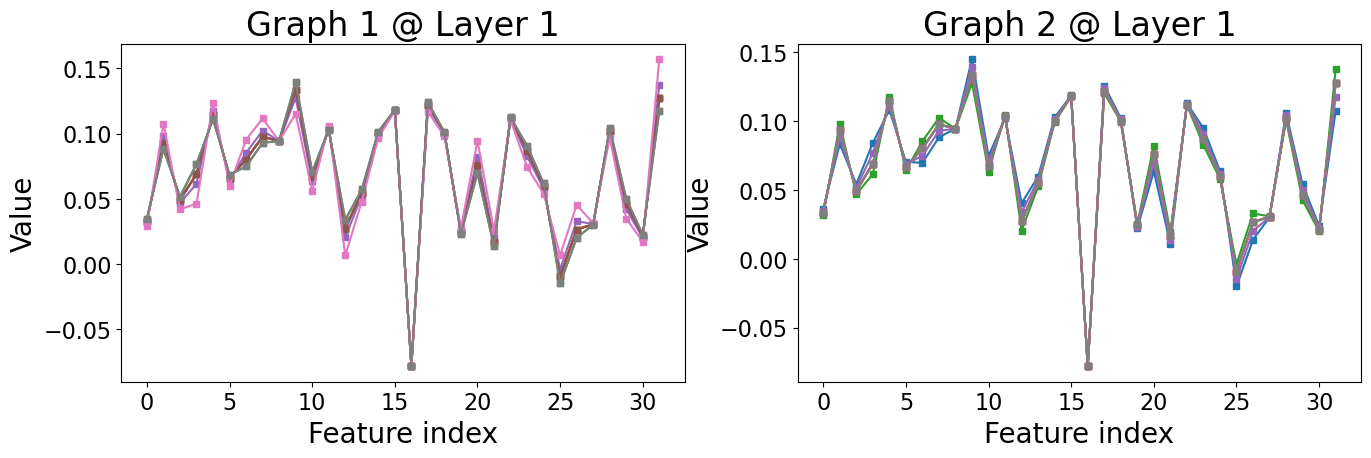

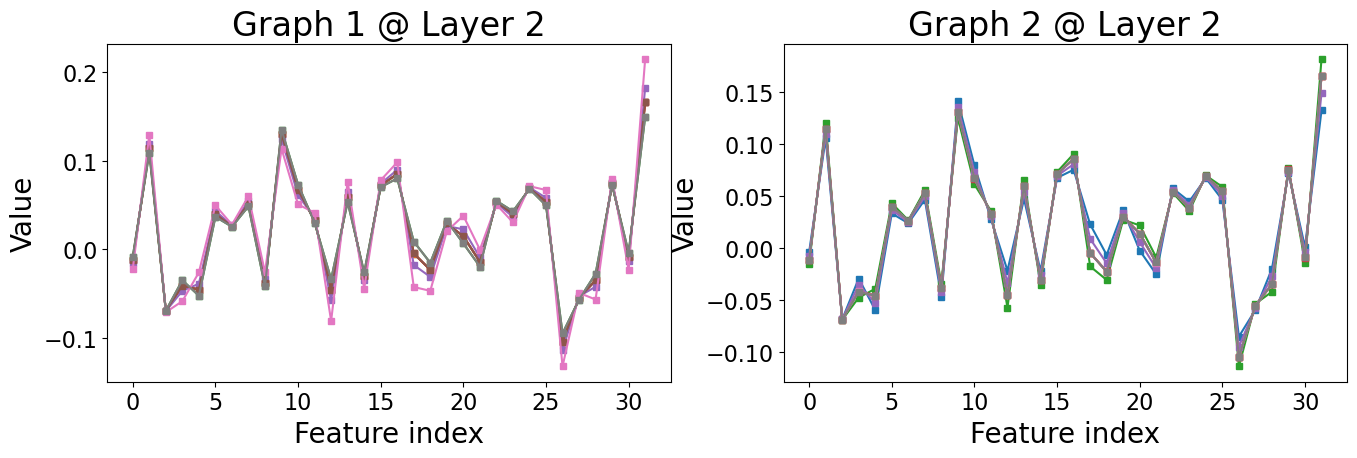

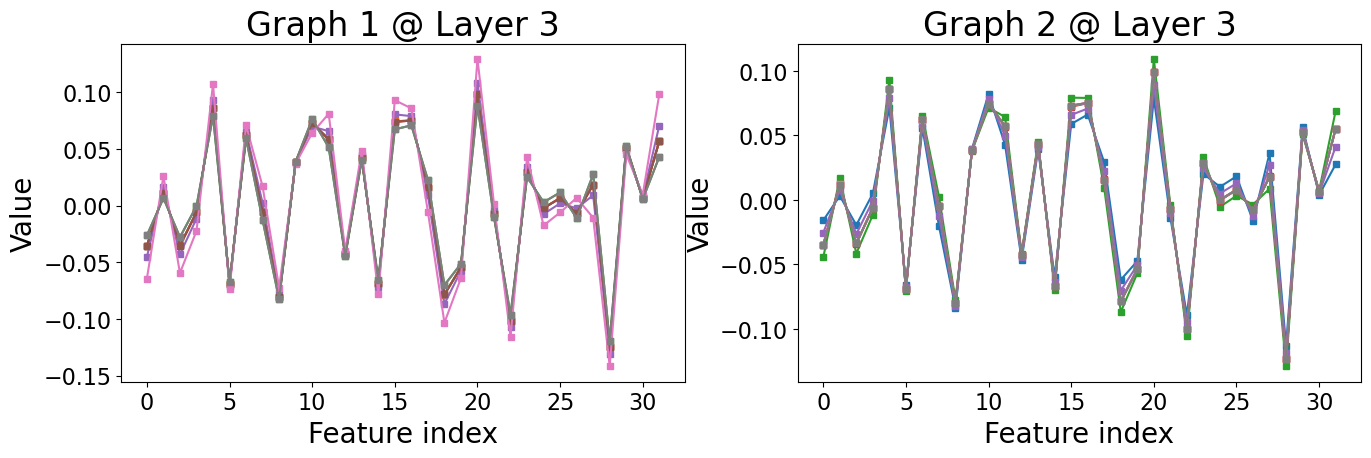

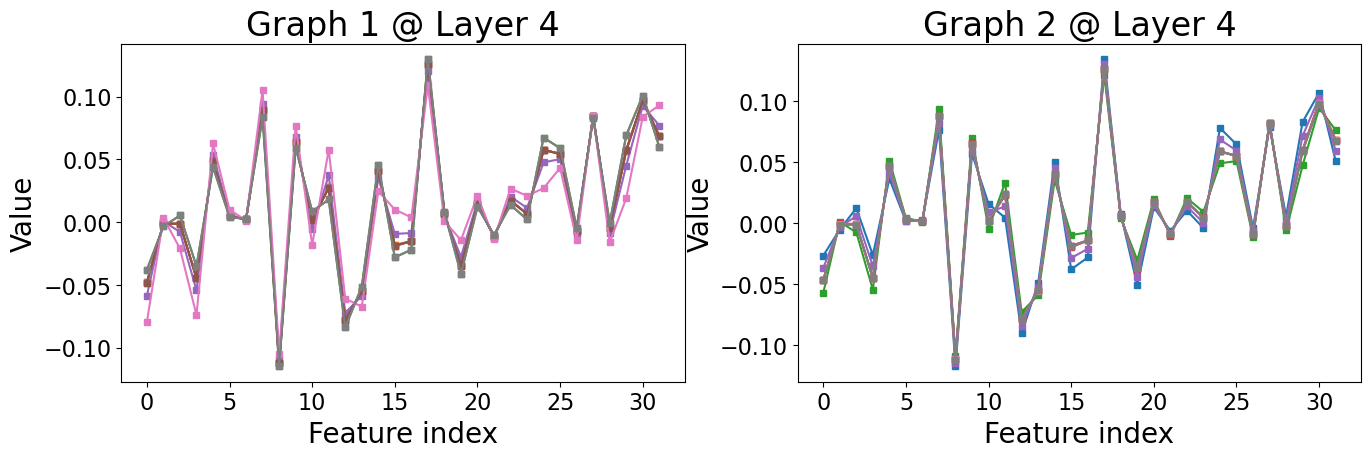

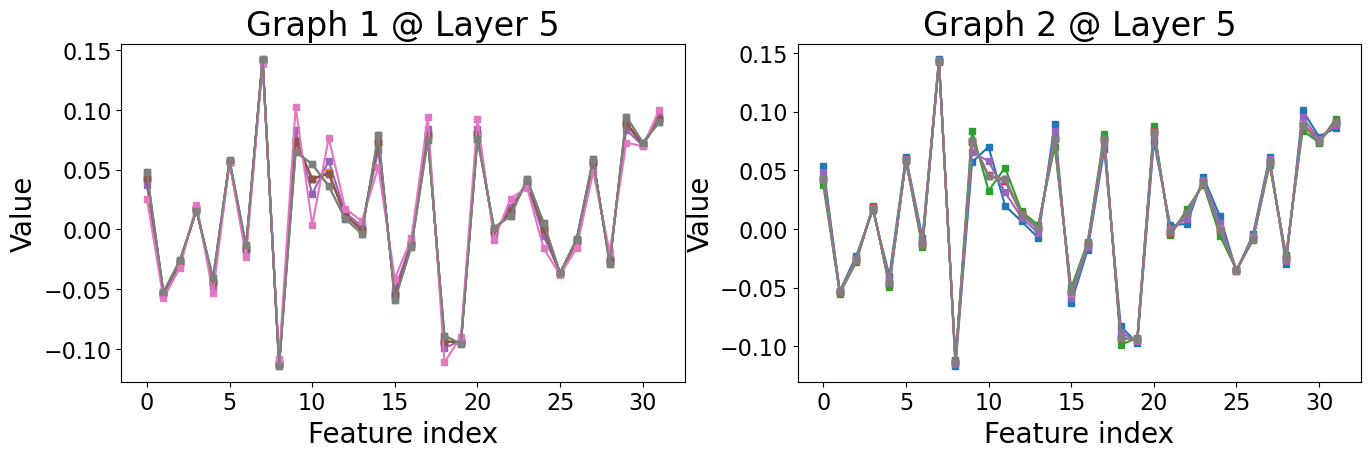

In [25]:
# Generate graphs of different sizes
N1, N2 = 8, 8
pe = 0.5
G1e,_ = generate_binomial_graph(num_nodes=N1, pe=pe, seed=1)
G2e,_ = generate_binomial_graph(num_nodes=N2, pe=pe, seed=1234)

# Plot graph features
ratio = 0.6
node_feats, graph_feats = graph_inference([G1e, G2e], model)
plot_graph_features(graph_feats, ratio=ratio, marker="s", markersize=5)

for k in node_feats.keys():
    node_feats_k = node_feats[k]
    plot_node_features(node_feats_k, N1=N1, N2=N2, layer=k, ratio=ratio, marker="s", markersize=5)

What happens if we take a graph matching network with an MLP for the node update function

Feature similarity Graph 1:
	False
	dE=1.0321604682062002e-16
	meanE=(e1_12: 0.0096184, e1_21: 0.0096184)

Features similarity Graph 2:
	False
	dE=8.803721640582296e-17
	meanE=(e2_12: 0.0099034, e2_21: 0.0099034)

## Euclidean distance between embeddings
	0.0005575933610089123


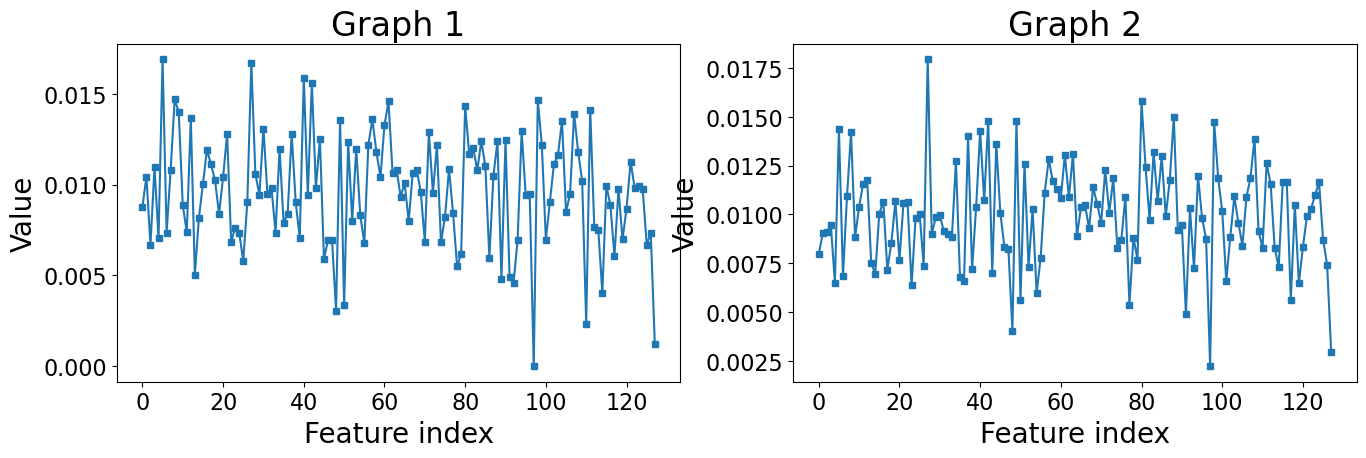

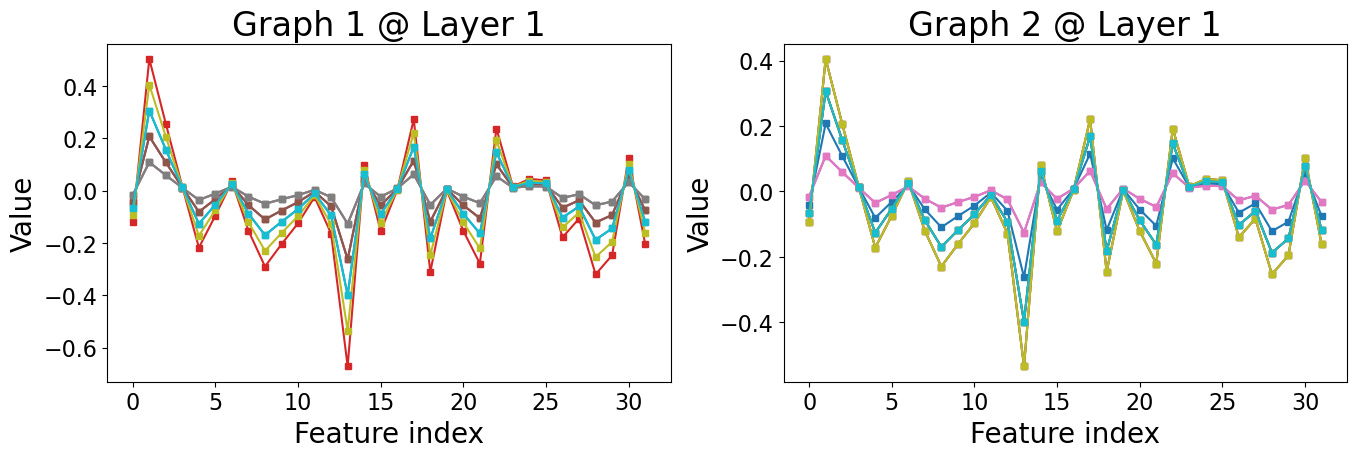

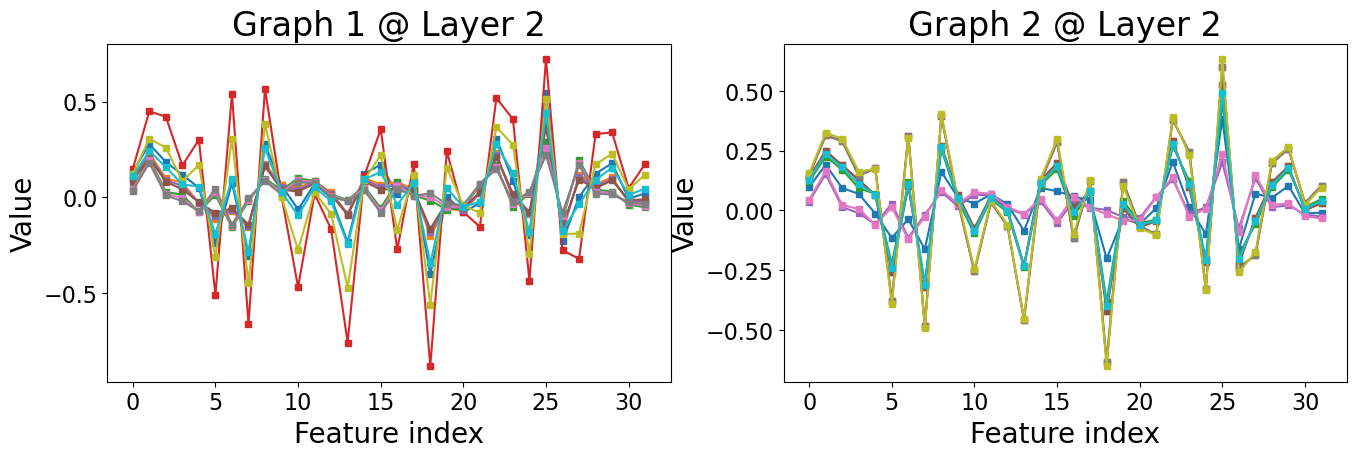

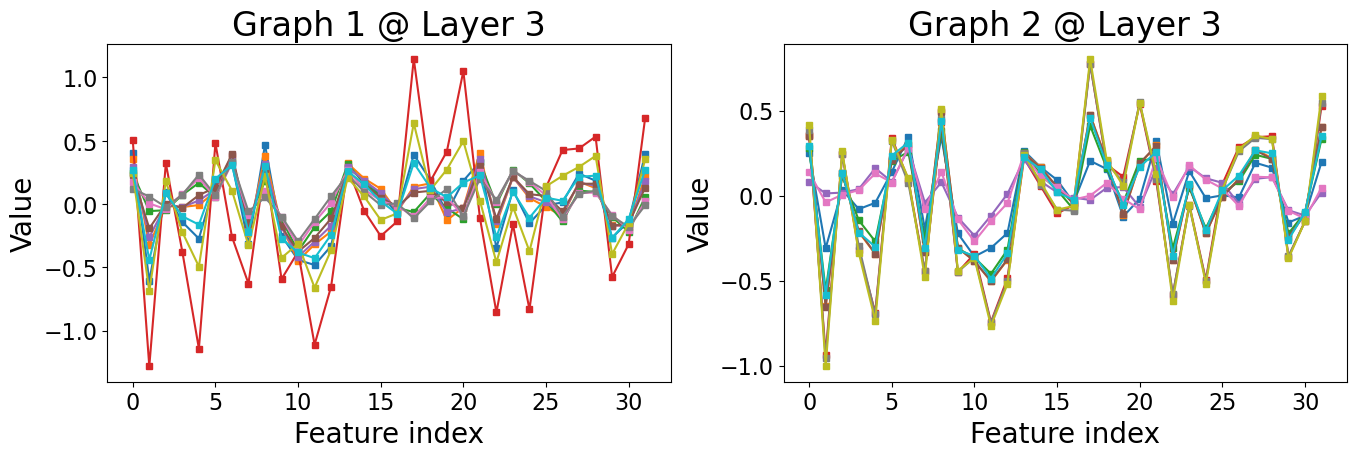

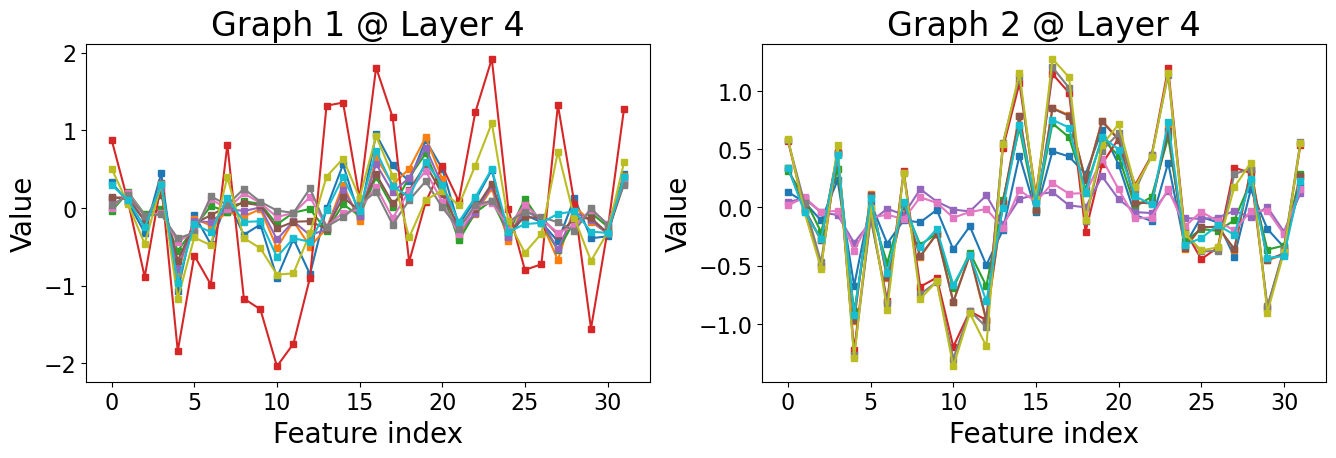

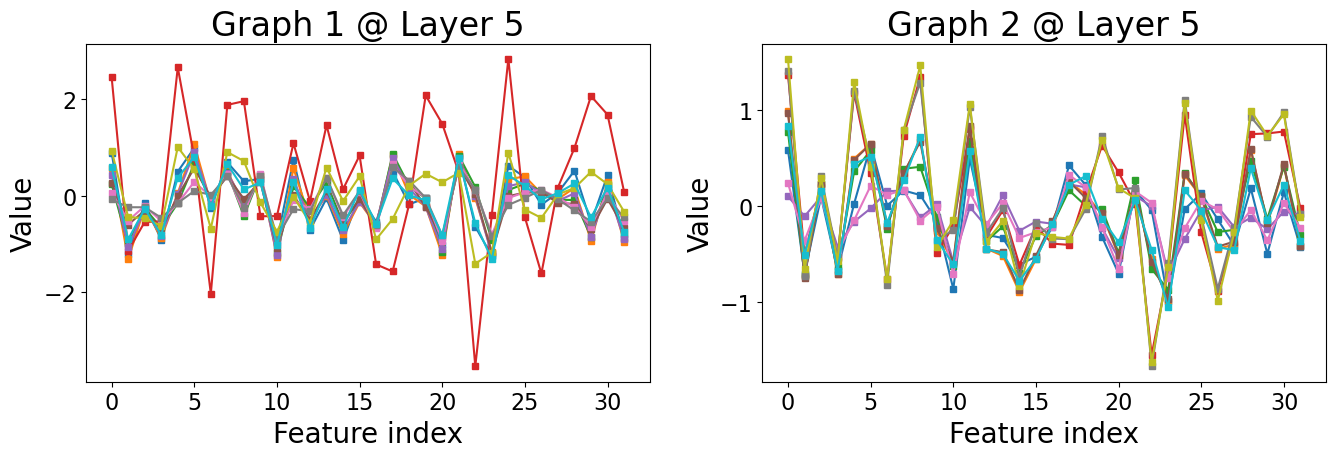

In [26]:
# Load and randomly initialize Siamese model
cfg.model.node_update_type = "mlp"
cfg.model.message_gain = 0.5
model = GraphMatchingNetwork(cfg)

# Perform symmetry check
symmetry_check(G1, G2, model)

# Plot graph features
ratio = 0.6
node_feats, graph_feats = graph_inference([G1, G2], model)

# Extract separate embeddings
e1, e2 = graph_feats[0], graph_feats[1]

# Check Eucl. distance between embeddings
d = euclidean_distance(e1, e2)
print(f"\n## Euclidean distance between embeddings\n\t{d}")

plot_graph_features(graph_feats, ratio=ratio, marker="s", markersize=5)

for k in node_feats.keys():
    node_feats_k = node_feats[k]
    plot_node_features(node_feats_k, N1=G1.number_of_nodes(), layer=k, ratio=ratio, marker="s", markersize=5)

Graph embedding network with MLP

Feature similarity Graph 1:
	True
	dE=0.0
	meanE=(e1_12: 0.0101026, e1_21: 0.0101026)

Features similarity Graph 2:
	True
	dE=0.0
	meanE=(e2_12: 0.0101022, e2_21: 0.0101022)

## Euclidean distance between embeddings
	1.3308346424878437e-08


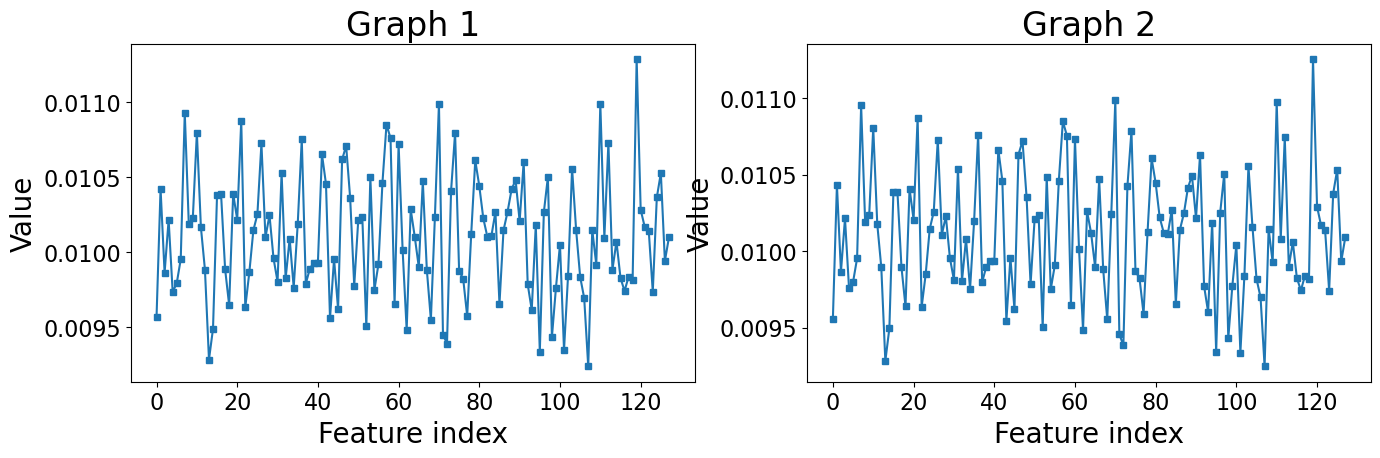

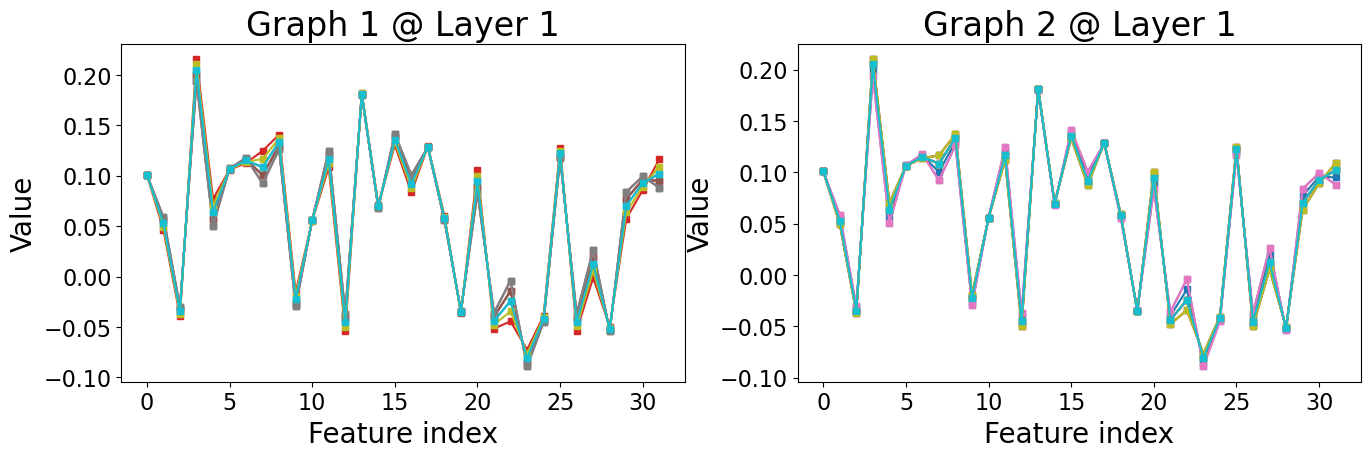

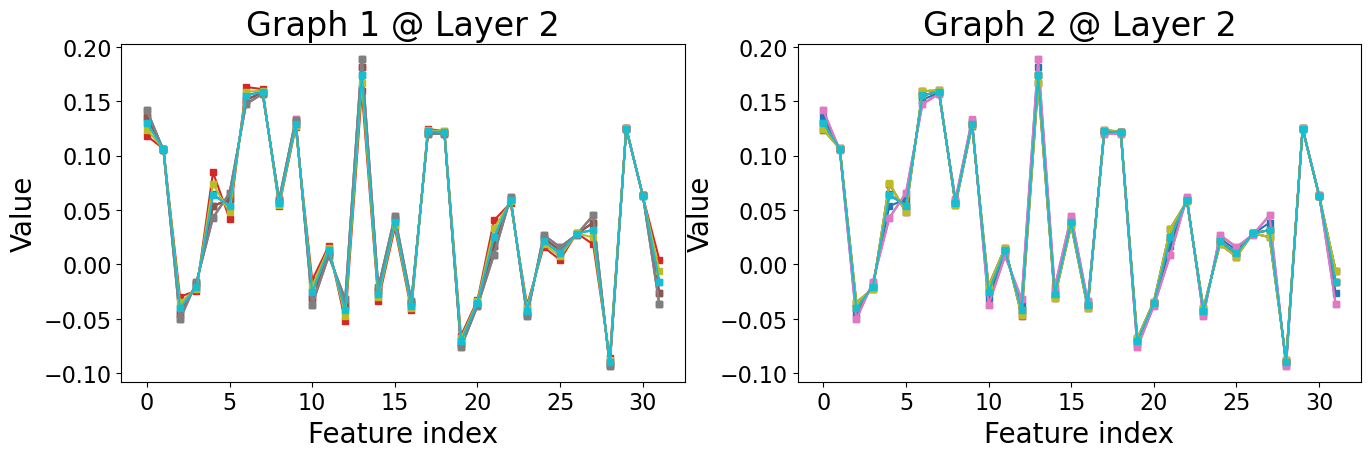

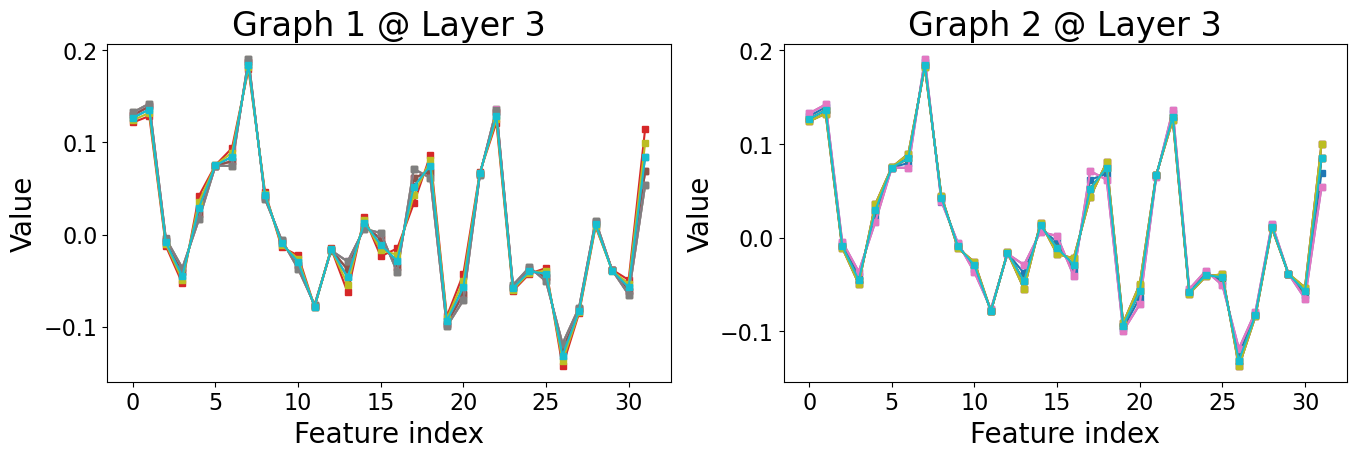

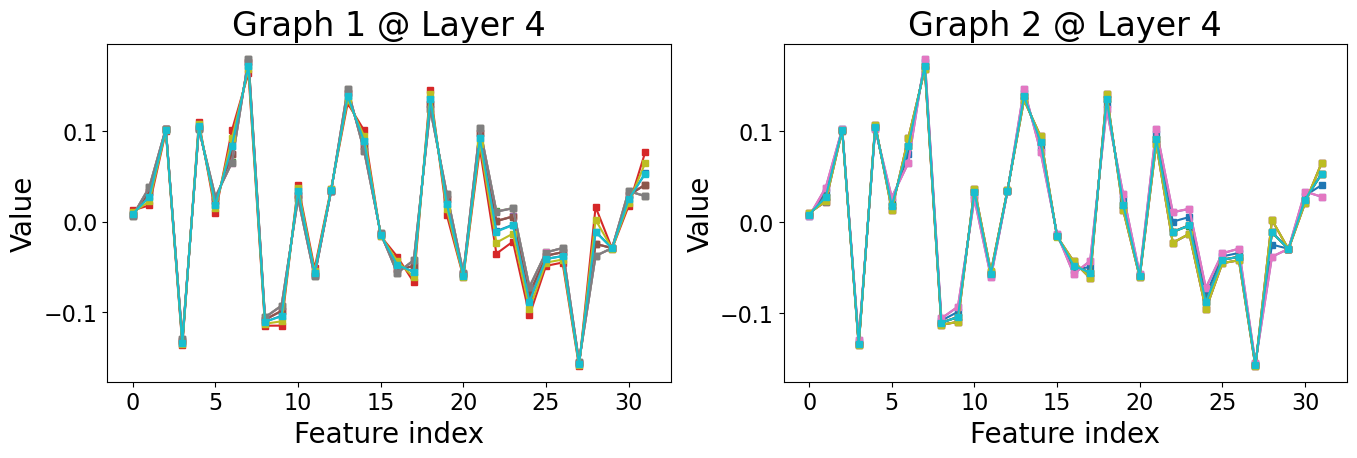

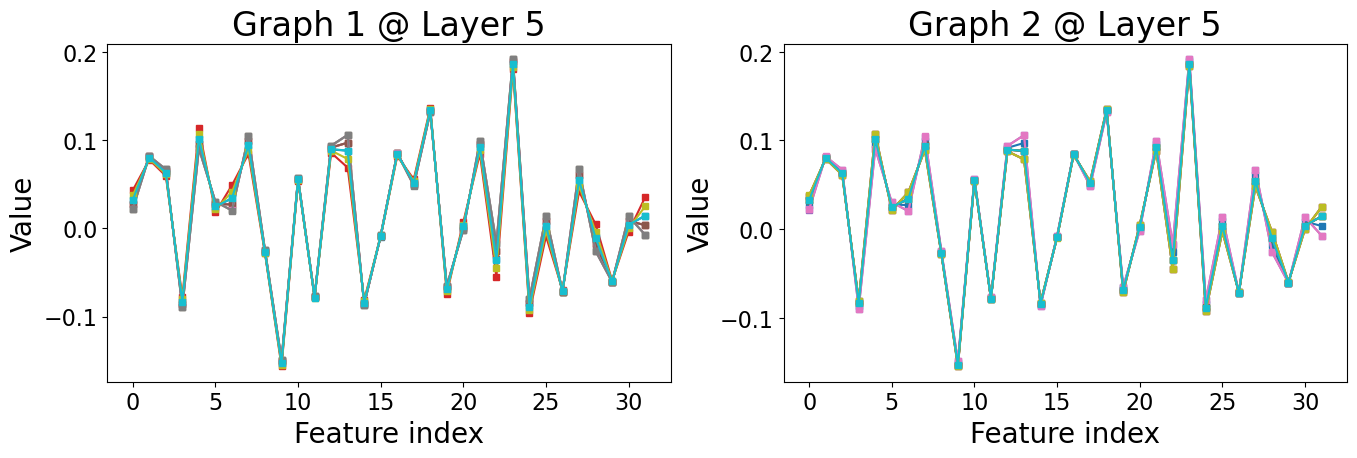

In [34]:
from model import GraphConvolutionNetwork

# Load and randomly initialize Siamese model
cfg.model.node_update_type = "gru"
model = GraphConvolutionNetwork(cfg)

# Perform symmetry check
symmetry_check(G1, G2, model)

# Plot graph features
ratio = 0.6
node_feats, graph_feats = graph_inference([G1, G2], model)

# Check Eucl. distance between embeddings
e1, e2 = graph_feats[0], graph_feats[1]
d = euclidean_distance(e1, e2)
print(f"\n## Euclidean distance between embeddings\n\t{d}")

# Plot graph features
plot_graph_features(graph_feats, ratio=ratio, marker="s", markersize=5)

# Plot node features
for k in node_feats.keys():
    node_feats_k = node_feats[k]
    plot_node_features(node_feats_k, N1=G1.number_of_nodes(), layer=k, ratio=ratio, marker="s", markersize=5)

## Observations so far

$\bullet$ GMN not symmetric exactly (tolerance ~ $10^{17}$) $\longrightarrow$ could be caused by floating point precision, has to do with computing attention.
$\bullet$ The different nodes in the same graph have very similar hidden node representations
$\bullet$ Two different graphs share very similar hidden representations as well
$\bullet$ Last two points, as also seen empirically, results in that graph-level representations that do look very similar as well

## Statistics: feature distributions

### Size of features

In [35]:
# Load and randomly initialize Siamese model
cfg.model.node_update_type = "mlp"
cfg.model.message_gain = 0.1
model = GraphConvolutionNetwork(cfg)

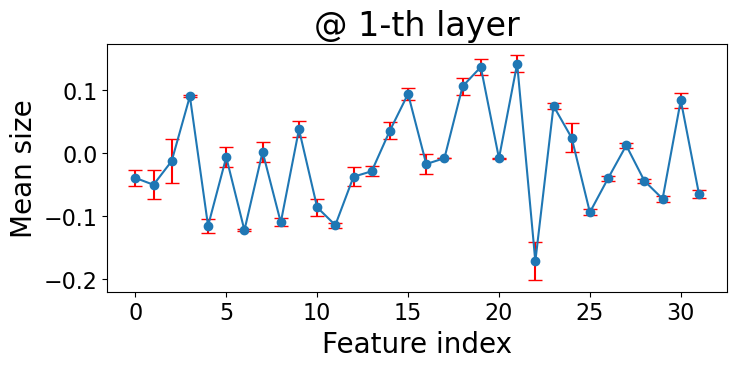

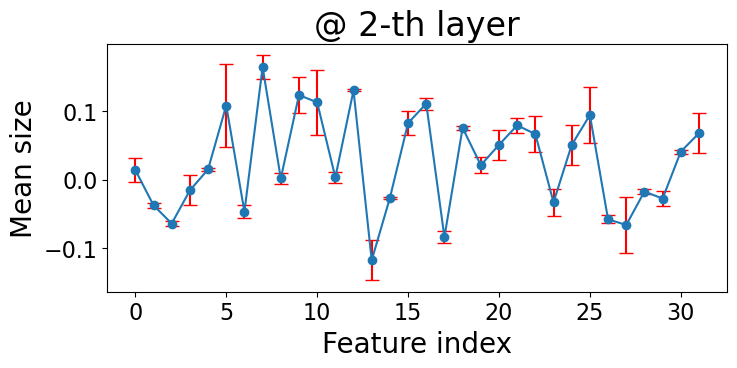

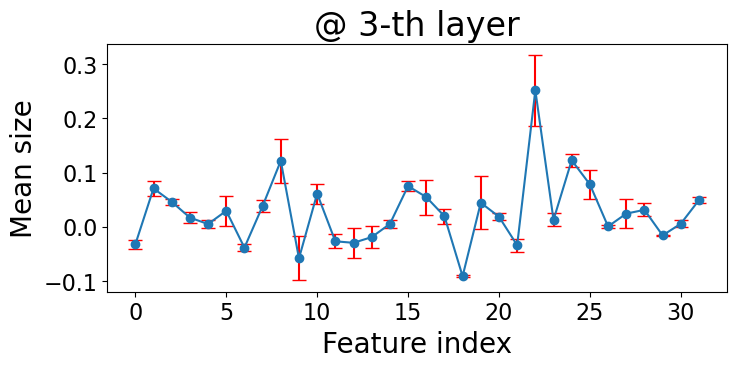

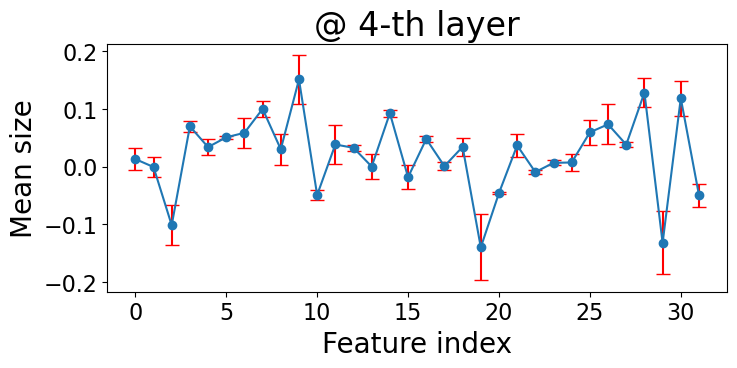

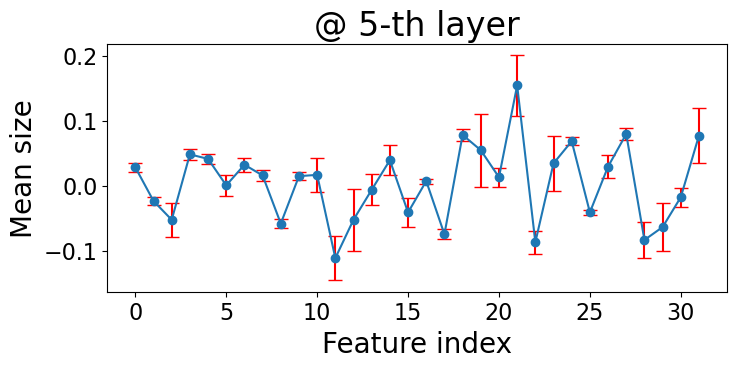

In [36]:
from plot import set_figure, set_aspect_ratio

def compute_feature_distribution(X, dim=0):

    # Compute distribution across nodes
    sig, mu = torch.std_mean(X, dim=dim)

    return mu, sig

def plot_errorbar(mu, sig, fc="white", title=None):

    # Global settings
    tc = "white" if fc == "black" else "black"

    fig, ax = set_figure(1,1,fs=8, fs_title=3, fs_axes=2.5, fs_xtick=2, fs_ytick=2, fc=fc)
    ax.errorbar(np.arange(len(mu)), mu, yerr=torch.sqrt(sig**2), fmt='-o', ecolor='red', capsize=5)

    # Customize the plot
    ax.axis(True)
    _ = ax.set_xlabel('Feature index', color=tc)
    _ = ax.set_ylabel('Mean size', color=tc)

    # Make up axis
    ax.spines['bottom'].set_color(tc)
    ax.spines['left'].set_color(tc)
    ax.tick_params(axis='x', colors=tc)
    ax.tick_params(axis='y', colors=tc)

     # Set aspect
    set_aspect_ratio(ax, ratio=0.4)

    # Title
    if title: ax.set_title(title)

# Inference
node_feats, graph_feats = graph_inference([G1, G2], model)

for k, X in node_feats.items():

    # Compute feature mean and variance
    N = G1.number_of_nodes()
    mu, sig = compute_feature_distribution(X[:N])

    # Plotting
    plot_errorbar(mu, sig, title=f"@ {k}-th layer")

Now for 100 samples (average)

torch.Size([11931, 32])


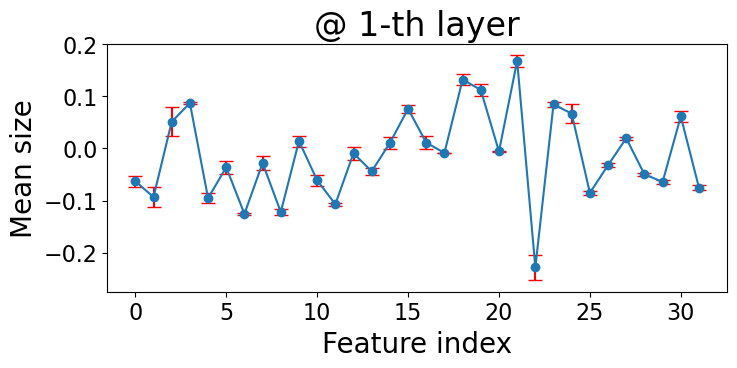

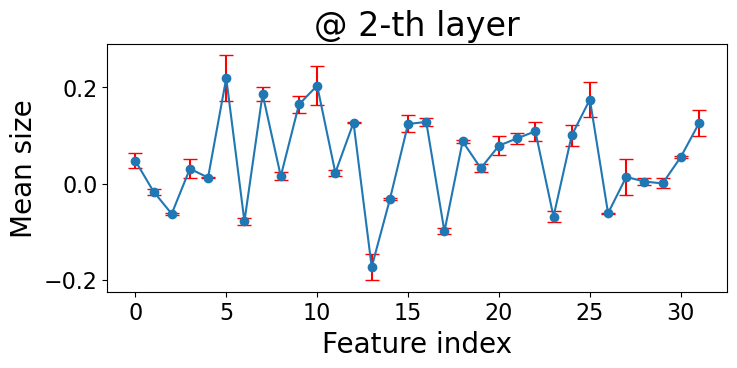

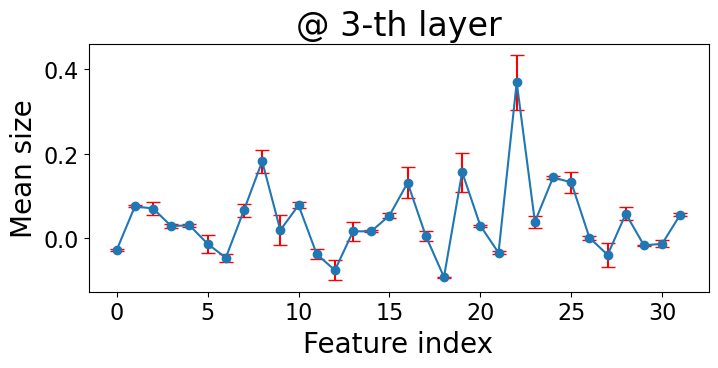

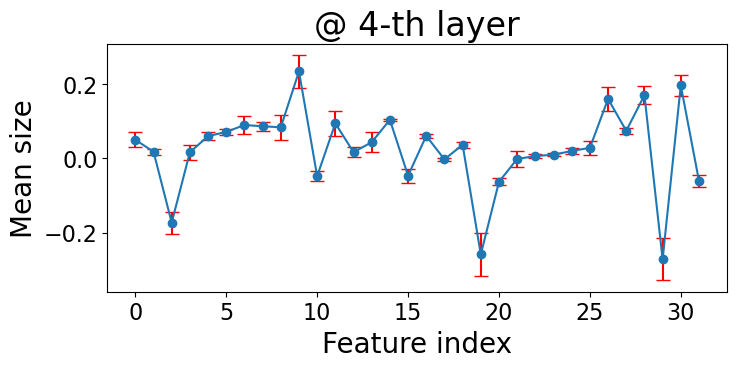

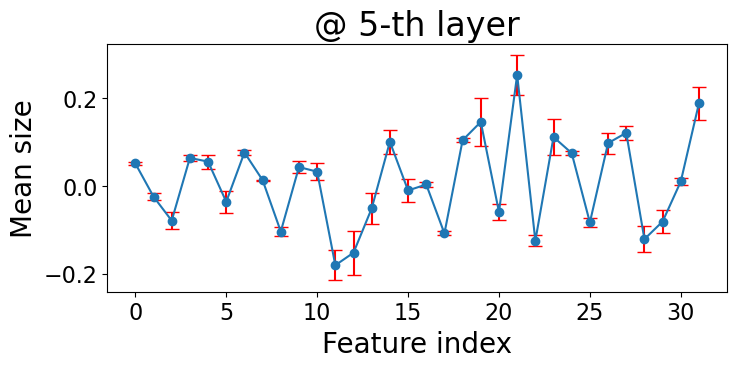

In [37]:
# Generate list of graphs
num_samples = 1000
num_nodes = [10, 15]
graphs = [generate_binomial_graph(num_nodes, pe, seed=i*100)[0] for i in range(num_samples)]

# Inference
node_feats, _ = graph_inference(graphs, model)

# 5-th layer feature map
X = node_feats[5]
print(X.shape)

# Compute feature mean and variance
mu, sig = compute_feature_distribution(X)

# Plotting
for k, X in node_feats.items():

    # Compute feature mean and variance
    N = G1.number_of_nodes()
    mu, sig = compute_feature_distribution(X[:N])

    # Plotting
    plot_errorbar(mu, sig, title=f"@ {k}-th layer")

### Correlation between node features